This sample code can be used as a guide on how to use the "analysis" module which was developed for the study titled "Task-relevant autoencoding" enhances machine learning for human neuroscience, submitted to Nature Communications.

In [5]:
import sys
import time
from google.colab import drive
drive.mount('/content/gdrive')
# The following line is to set the path to the 'analysis.py' directory. Please change this address appropriately
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/Vincent') # please change this directory appropriately
from analysis import *
%load_ext autoreload
%autoreload 2
%pylab inline
SEED = 42
import os
import random as rn
import tensorflow.compat.v1 as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


Importing the MNIST dataset and scaling the features

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.reshape(X_train/255, (-1,X_train.shape[1]**2))
X_test = np.reshape(X_test/255, (-1,X_test.shape[1]**2))

classes = np.unique(y_test)
class_number = len(classes)
y_categ_train = to_categorical(y_train, num_classes=class_number)
y_categ_test = to_categorical(y_test, num_classes=class_number)

Setting up and training the TRACE model on MNIST dataset

In [11]:
start_s = time.time()
encoding_dims = [2, 5, 10] #setting up the bottleneck dimensions
BN_class_accuracy = []
recons_class_accuracy = []
recons_fidelity = []
recons_class_specificity = []
corr_recons_list = []
num_epoch = 300
SEED = 12345
for encoding_dim in encoding_dims:
  reset_seed(SEED = SEED)
  decoder, encoder, ES = TRACE(encoding_dim, X_train, class_number) #setting up the TRACE model
  decoder.fit(X_train, [X_train, y_categ_train], epochs= num_epoch, shuffle=True, validation_data=(X_test,[X_test, y_categ_test]), verbose=0) # Trainging the TRACE model
  Bneck = encoder.predict(X_test) #predicting the bottleneck feattures using the test dataset
  [decoded, classify] = decoder.predict(X_test) # predicting the reconstructed input usign the test datatset

  ### logistic classifier for reconstruction ###
  reset_seed(SEED = SEED)
  classifier_decoded,_ = log_classifier(decoded, class_number) #setting up the logistic classifier for recosntructed input
  history_decoded = classifier_decoded.fit(decoded, y_categ_test, epochs=num_epoch, shuffle=True, validation_split = 0.2, verbose=0) #training the logistic classifier
  recons_class_accuracy.append(history_decoded.history['val_accuracy'][-1])

  ### reonstruction fidelity and reconstruction class specificity ###
  corr = np.corrcoef(decoded, X_test)[:len(y_test), len(y_test):]
  corr_recons = np.corrcoef(decoded)
  corr_recons_list.append(corr_recons)
  recons_fidelity.append(fidelity(corr))
  recons_class_specificity.append(specificity(corr_recons, y_test))

### logistic classifier for input ###
reset_seed(SEED = SEED)
classifier_input, _ = log_classifier(X_test, class_number) #setting up the logistic classifier for the input
history_input = classifier_input.fit(X_test, y_categ_test, epochs=num_epoch, shuffle=True, validation_split = 0.2, verbose=0) #training the logistic classifier
input_class_accuracy = history_input.history['val_accuracy'][-1]

### input class specificity ###
corr_input = np.corrcoef(X_test)
input_class_specificity = specificity(corr_input, y_test)

start_e = time.time()
time_elapsed = (start_e-start_s)/60
print('elapsed time using google colab is ' + str(time_elapsed)+ ' minutes')

training TRACE for drop= 0.02, activation_BT= linear, learning_rate= 0.0001
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
training TRACE for drop= 0.02, activation_BT= linear, learning_rate= 0.0001
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
training TRACE for drop= 0.02, activation_BT= linear, learning_rate= 0.0001
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
elapsed time using google colab-pro is 115.58907452027003 minutes


The folowwing cell plot reconstuction class accrucary of MNIST dataset using the TRACE model for the bottleneck dimensionality of 2, 5, 10.

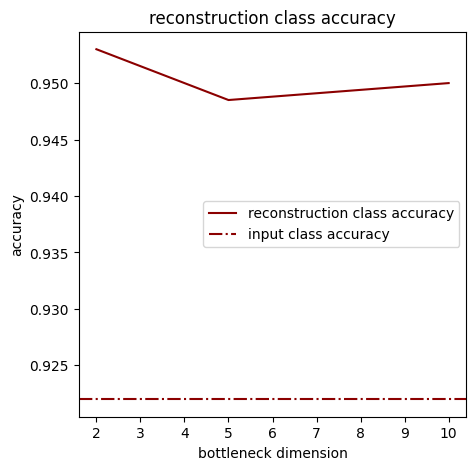

In [12]:
encoding_dims = [2, 5, 10]
fig = plt.figure(figsize=(5,5))
plt.plot(encoding_dims, recons_class_accuracy, c='darkred', label = 'reconstruction class accuracy')
plt.axhline(input_class_accuracy, c='darkred', linestyle='-.', label = 'input class accuracy')
plt.title('reconstruction class accuracy')
plt.xlabel('bottleneck dimension')
plt.ylabel('accuracy')
plt.legend()
plt.show()

The following cell plot reconstuction class specificity of MNIST dataset using the TRACE model for the bottleneck dimensionality of 2, 5, 10.

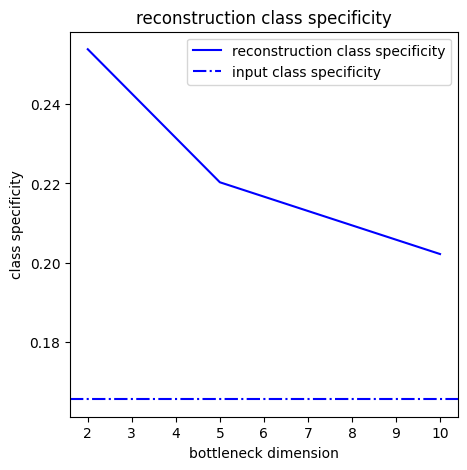

In [13]:
fig2 = plt.figure(figsize=(5,5))
plt.plot(encoding_dims, recons_class_specificity, c='blue', label = 'reconstruction class specificity')
plt.axhline(input_class_specificity, c='blue', linestyle='-.', label = 'input class specificity')
plt.title('reconstruction class specificity')
plt.xlabel('bottleneck dimension')
plt.ylabel('class specificity')
plt.legend()
plt.show()

The following cell shows the cohen's d effect size for within Vs between class correlation for input and reconstructed input using the TRACE model

In [14]:
corr_df_in = dataframed(corr_input, y_test)
corr_df_out = dataframed(corr_recons_list[0], y_test)
within_in, between_in = withinVSbetween(2, corr_df_in)
within_out, between_out = withinVSbetween(2, corr_df_out)
consd_in = cohnsd(within_in, between_in) #effect size of the within vs between class of input
consd_out = cohnsd(within_out, between_out) #effect size of the within vs between class of reconstucted input
print('the effect size for within vs between class correlation of input is ' + str(consd_in))
print('the effect size for within vs between class correlation of recosntructed input for is ' + str(consd_out))

the effect size for within vs between class correlation of input is 0.8610434941259639
the effect size for within vs between class correlation of recosntructed input for is 1.976803102984001
